In [7]:
#Explainability in InfoMax VAE
#First part using captum
#For G protein family

%cd ProtWaveVAE/Pfam_analysis/
!pwd

[Errno 2] No such file or directory: 'ProtWaveVAE/Pfam_analysis/'
/storage/ice1/6/9/khari8/condaProtein/vqvae/ProtWaveVAE/Pfam_analysis
/storage/ice1/6/9/khari8/condaProtein/vqvae/ProtWaveVAE/Pfam_analysis


/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [8]:
!pip install captum
!pip install seaborn

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
import shap
from shap import DeepExplainer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from train_on_pfam import call_model
from generate_samples import load_weights
from source.pfam_preprocess import prepare_Gprotein_dataset
import source.pfam_preprocess as pfam_prep

In [10]:
# Define arguments (matching the training configuration)
class Args:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    class_labels = 21
    z_dim = 4
    encoder_rates = 0
    C_in = 21
    C_out = 256
    alpha = 0.1
    enc_kernel = 3
    num_fc = 3
    wave_hidden_state = 128
    head_hidden_state = 512
    num_dil_rates = 5
    dec_kernel_size = 3
    lr = 1e-4
    xi_weight = 10
    alpha_weight = 0.99
    lambda_weight = 1
    alignment = False
    learning_option = 'unsupervised'

args = Args()

# Set protein length based on the dataset
protein_len = 205  # Replace with actual sequence length if known

In [11]:
# Construct the model
model = call_model(args, protein_len=protein_len).model

# Load weights
weights_path = './outputs/train_sess/pfam/S1A/S1A_model.pth'
args.weights_path = weights_path
model = load_weights(args, model)

# Set the model to evaluation mode
model.eval()

# Test with dummy input
dummy_input = torch.zeros((1, protein_len, args.C_in)).to(args.DEVICE)
output = model(dummy_input)

# Verify output
print("Model output shape:", output[0].shape)

/storage/ice1/6/9/khari8/condaProtein/vqvae/ProtWaveVAE/Pfam_analysis/generate_samples.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(

Model output shape: torch.Size([1, 205, 21])


In [12]:
# Preprocess the G-protein data
train_data_path = "./data/protein_families/S1A/pfam_S1A.csv"
train_seq_num, train_seq_OH = prepare_Gprotein_dataset(train_data_path, alignment=False)
test_data_path = "./outputs/prediction/pfam/S1A/S1A_sample_sequences.csv"
test_seq_num, test_seq_OH = prepare_Gprotein_dataset(test_data_path, alignment=False)

In [13]:
encoder_model = model.inference
#decoder_model = model.generator

In [14]:
training_data = torch.tensor(train_seq_OH[:100], dtype = torch.float32)
test_data = torch.tensor(train_seq_OH[100:110], dtype = torch.float32)
training_data = training_data.to(args.DEVICE)
test_data = test_data.to(args.DEVICE)
encoder_model.to(args.DEVICE)
#decoder_model.to(args.DEVICE)

GatedCNN_encoder(
  (initial_conv_blocks): ModuleList(
    (0): Conv1d(21, 256, kernel_size=(1,), stride=(1,))
  )
  (signal_convs): ModuleList(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), bias=False)
    (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(2,), bias=False)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(4,), bias=False)
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(8,), bias=False)
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(16,), bias=False)
    (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(32,), bias=False)
  )
  (gate_convs): ModuleList(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), bias=False)
    (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(2,), bias=False)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(4,), bias=False)
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), dilation=(8,), bias=False)
    (4): Co

In [15]:
class SHAPWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SHAPWrapper, self).__init__()
        self.model = model
        self.model.eval()

    def forward(self, x):
        return self.model(x)[0]  # Extract the first element of the tuple

wrapped_model = SHAPWrapper(encoder_model)

In [16]:
#mapping for proteins
protein_string = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','T','V','W','Y','-']

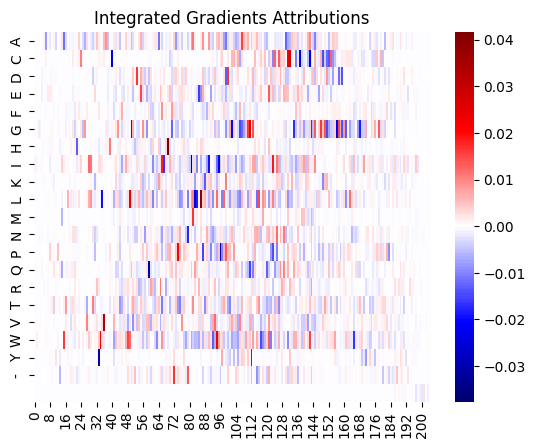

In [17]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(wrapped_model)
attributions0, delta0 = ig.attribute(training_data.permute(0,2,1), target=0, return_convergence_delta=True)
attribution_map0 = attributions0.sum(axis=0).cpu().numpy()  # Sum over test data
sns.heatmap(attribution_map0, yticklabels = protein_string, cmap='seismic', center=0)
plt.title("Integrated Gradients Attributions")
plt.show()


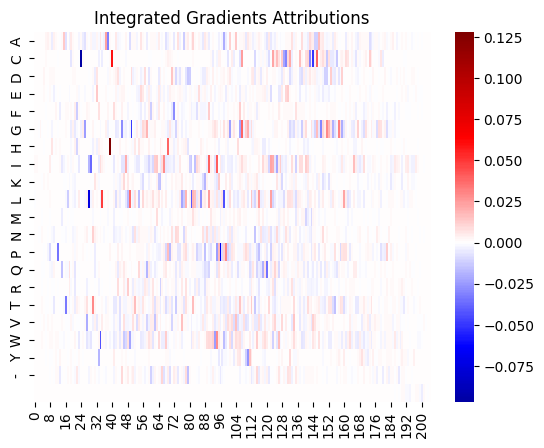

In [18]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(wrapped_model)
attributions1, delta1 = ig.attribute(training_data.permute(0,2,1), target=1, return_convergence_delta=True)
attribution_map1 = attributions1.sum(axis=0).cpu().numpy()  # Sum over test data
sns.heatmap(attribution_map1, yticklabels = protein_string, cmap='seismic', center=0)
plt.title("Integrated Gradients Attributions")
plt.show()


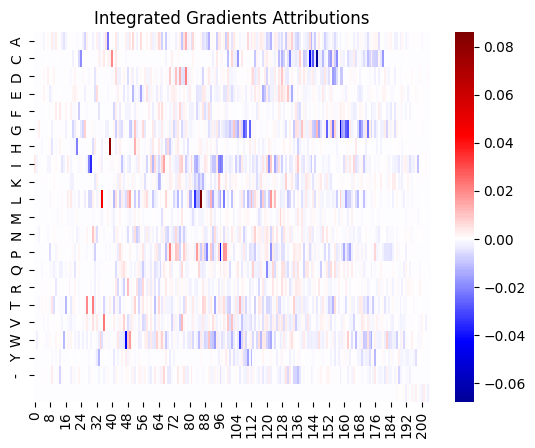

In [19]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(wrapped_model)
attributions2, delta2 = ig.attribute(training_data.permute(0,2,1), target=2, return_convergence_delta=True)
attribution_map2 = attributions2.sum(axis=0).cpu().numpy()  # Sum over test data
sns.heatmap(attribution_map2, yticklabels = protein_string, cmap='seismic', center=0)
plt.title("Integrated Gradients Attributions")
plt.show()


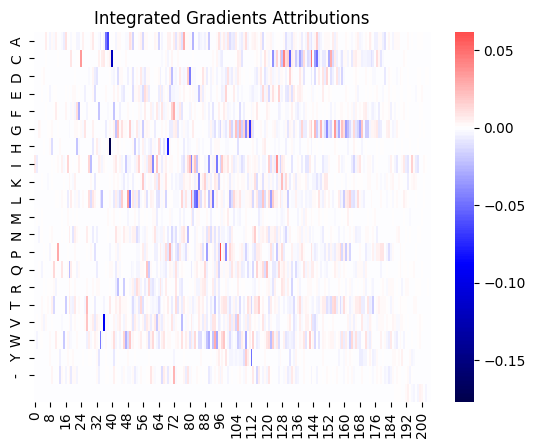

In [20]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(wrapped_model)
attributions3, delta3 = ig.attribute(training_data.permute(0,2,1), target=3, return_convergence_delta=True)
attribution_map3 = attributions3.sum(axis=0).cpu().numpy()  # Sum over test data
sns.heatmap(attribution_map3, yticklabels = protein_string, cmap='seismic', center=0)
plt.title("Integrated Gradients Attributions")
plt.show()


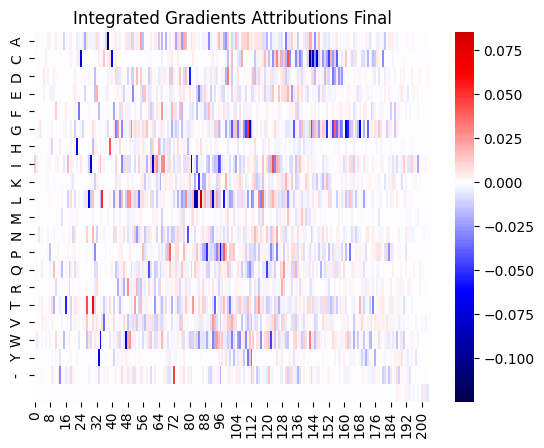

In [21]:
attribution_map_final = attribution_map0+attribution_map1+attribution_map2+attribution_map3
sns.heatmap(attribution_map_final, yticklabels = protein_string, cmap='seismic', center=0)
plt.title("Integrated Gradients Attributions Final")
plt.show()

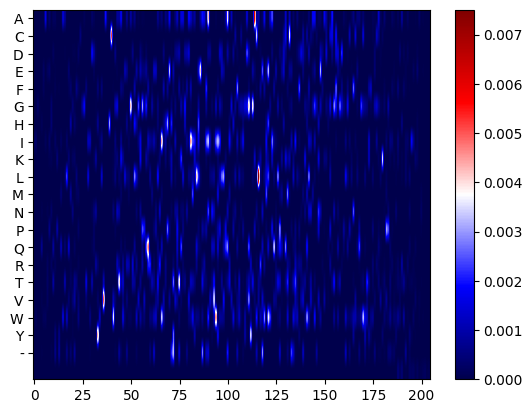

In [22]:
from captum.attr import GradientShap

reference_input = torch.zeros_like(test_data.permute(0,2,1)).to(args.DEVICE)

gradient_shap = GradientShap(wrapped_model)

attributions0, delta0 = gradient_shap.attribute(test_data.permute(0,2,1), baselines = reference_input, target=0, return_convergence_delta = True)

attributions_values0 = attributions0.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values0.sum(axis=0)), cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

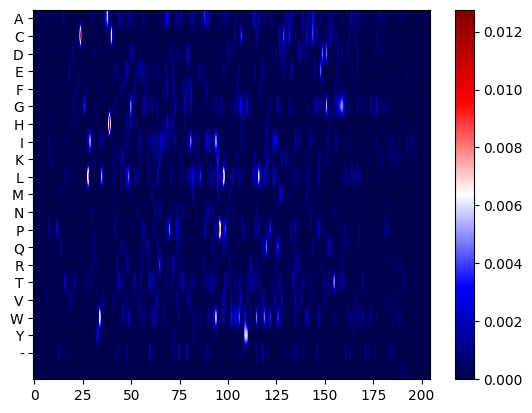

In [23]:
from captum.attr import GradientShap

reference_input = torch.zeros_like(test_data.permute(0,2,1)).to(args.DEVICE)

gradient_shap = GradientShap(wrapped_model)

attributions1, delta1 = gradient_shap.attribute(test_data.permute(0,2,1), baselines = reference_input, target=1, return_convergence_delta = True)

attributions_values1 = attributions1.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values1.sum(axis=0)), cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

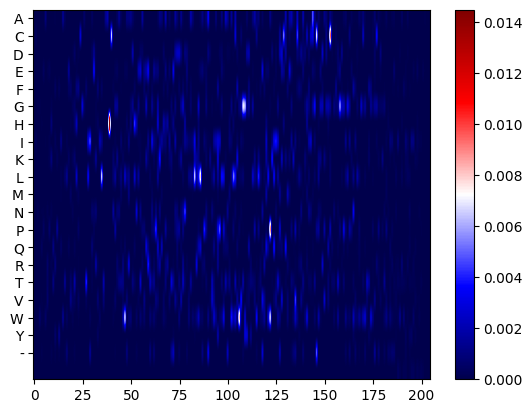

In [24]:
from captum.attr import GradientShap

reference_input = torch.zeros_like(test_data.permute(0,2,1)).to(args.DEVICE)

gradient_shap = GradientShap(wrapped_model)

attributions2, delta2 = gradient_shap.attribute(test_data.permute(0,2,1), baselines = reference_input, target=2, return_convergence_delta = True)

attributions_values2 = attributions2.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values2.sum(axis=0)), cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

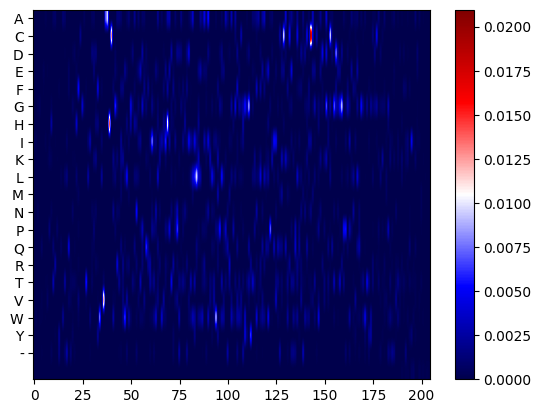

In [25]:
from captum.attr import GradientShap

reference_input = torch.zeros_like(test_data.permute(0,2,1)).to(args.DEVICE)

gradient_shap = GradientShap(wrapped_model)

attributions3, delta3 = gradient_shap.attribute(test_data.permute(0,2,1), baselines = reference_input, target=3, return_convergence_delta = True)

attributions_values3 = attributions3.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values3.sum(axis=0)), cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

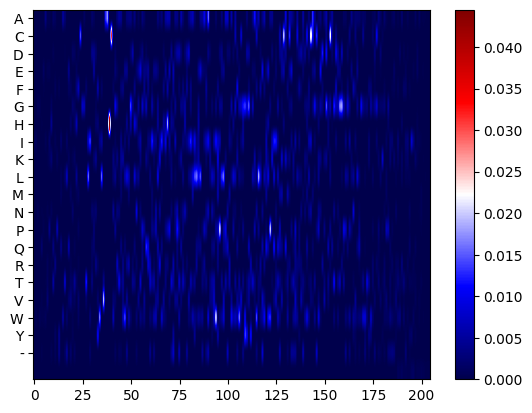

In [26]:
attributions_value_final = np.abs(attributions_values0.sum(axis=0))+np.abs(attributions_values1.sum(axis=0))+np.abs(attributions_values2.sum(axis=0))+np.abs(attributions_values3.sum(axis=0))
plt.imshow(attributions_value_final, cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


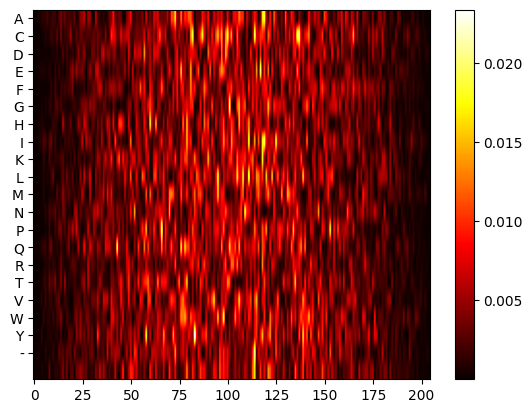

In [27]:
from captum.attr import GuidedBackprop

guided_backprop = GuidedBackprop(wrapped_model)

attributions0 = guided_backprop.attribute(test_data.permute(0,2,1), target=0)

attributions_values0 = attributions0.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values0.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


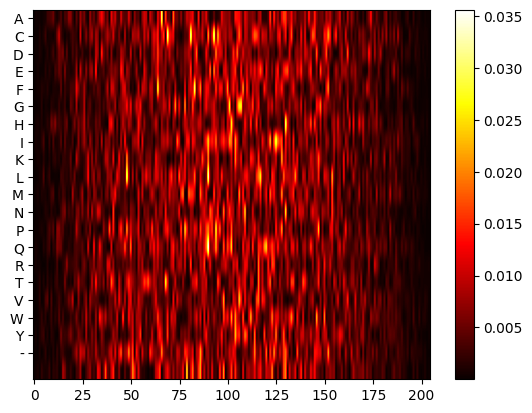

In [28]:
from captum.attr import GuidedBackprop

guided_backprop = GuidedBackprop(wrapped_model)

attributions1 = guided_backprop.attribute(test_data.permute(0,2,1), target=1)

attributions_values1 = attributions1.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values1.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


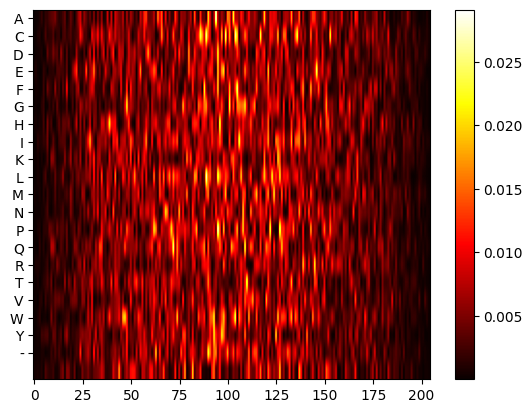

In [29]:
from captum.attr import GuidedBackprop

guided_backprop = GuidedBackprop(wrapped_model)

attributions2 = guided_backprop.attribute(test_data.permute(0,2,1), target=2)

attributions_values2 = attributions2.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values2.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/hice1/khari8/.conda/envs/pySCAenv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


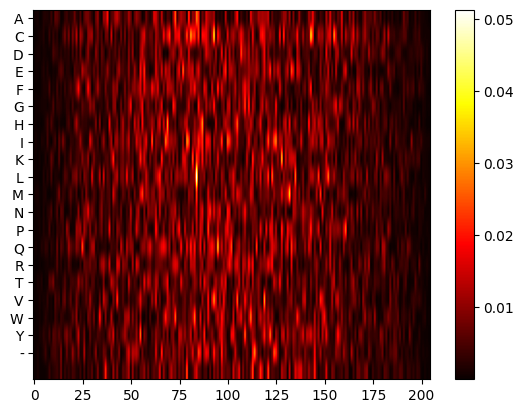

In [30]:
from captum.attr import GuidedBackprop

guided_backprop = GuidedBackprop(wrapped_model)

attributions3 = guided_backprop.attribute(test_data.permute(0,2,1), target=3)

attributions_values3 = attributions3.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values3.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

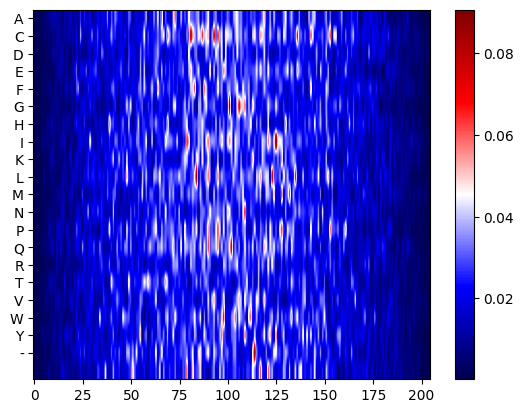

In [31]:
attributions_value_final = np.abs(attributions_values0.sum(axis=0))+np.abs(attributions_values1.sum(axis=0))+np.abs(attributions_values2.sum(axis=0))+np.abs(attributions_values3.sum(axis=0))
plt.imshow(attributions_value_final, cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

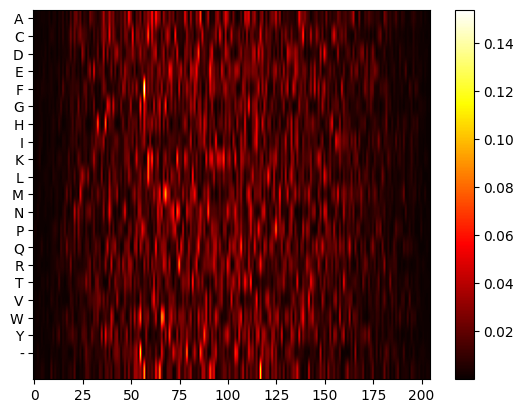

In [32]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(gradient_shap)

attributions0 = noise_tunnel.attribute(test_data.permute(0,2,1), baselines = reference_input,target=0)

attributions_values0 = attributions0.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values0.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

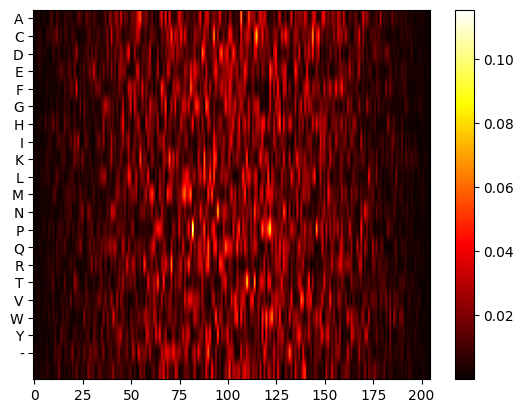

In [33]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(gradient_shap)

attributions1 = noise_tunnel.attribute(test_data.permute(0,2,1), baselines = reference_input,target=1)

attributions_values1 = attributions1.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values1.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

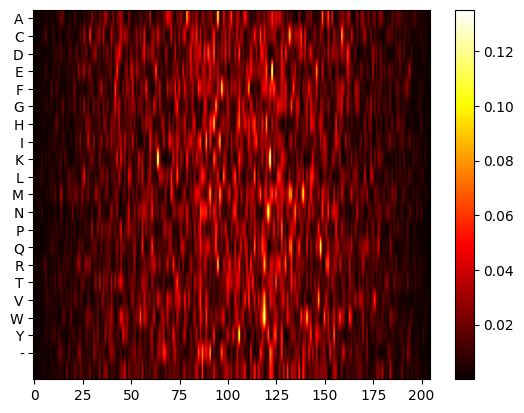

In [34]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(gradient_shap)

attributions2 = noise_tunnel.attribute(test_data.permute(0,2,1), baselines = reference_input,target=2)

attributions_values2 = attributions2.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values2.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

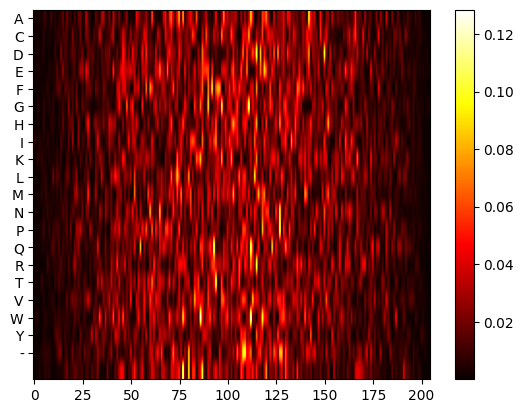

In [35]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(gradient_shap)

attributions3 = noise_tunnel.attribute(test_data.permute(0,2,1), baselines = reference_input,target=3)

attributions_values3 = attributions3.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values3.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

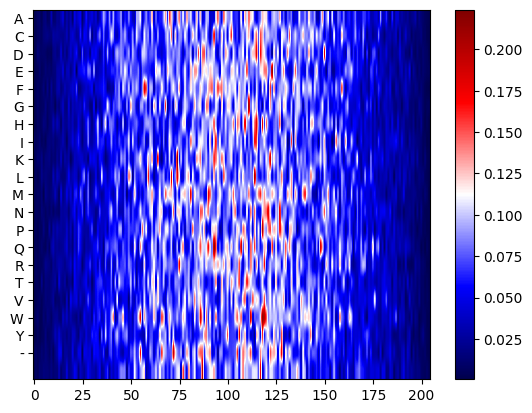

In [36]:
attributions_value_final = np.abs(attributions_values0.sum(axis=0))+np.abs(attributions_values1.sum(axis=0))+np.abs(attributions_values2.sum(axis=0))+np.abs(attributions_values3.sum(axis=0))
plt.imshow(attributions_value_final, cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

Feature Ablation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

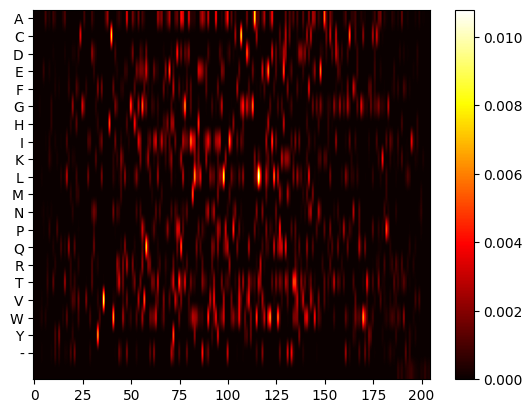

In [37]:
from captum.attr import FeatureAblation

feature_ablation = FeatureAblation(wrapped_model)

attributes0 = feature_ablation.attribute(test_data.permute(0,2,1), target = 0, show_progress = True)

attributes0 = attributes0.cpu().detach().numpy()
plt.imshow(np.abs(attributes0.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Ablation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

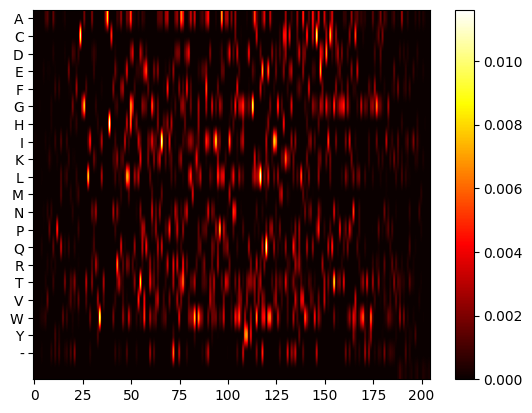

In [38]:
from captum.attr import FeatureAblation

feature_ablation = FeatureAblation(wrapped_model)

attributes1 = feature_ablation.attribute(test_data.permute(0,2,1), target = 1, show_progress = True)

attributes1 = attributes1.cpu().detach().numpy()
plt.imshow(np.abs(attributes1.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Ablation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

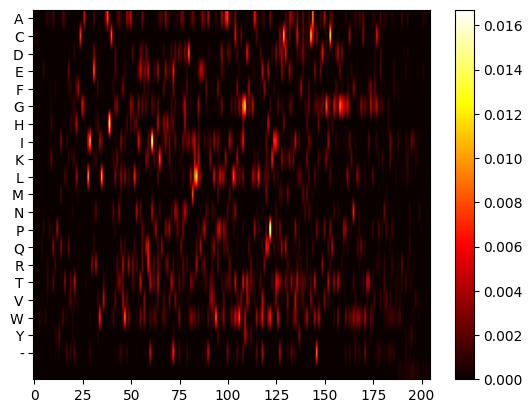

In [39]:
from captum.attr import FeatureAblation

feature_ablation = FeatureAblation(wrapped_model)

attributes2 = feature_ablation.attribute(test_data.permute(0,2,1), target = 2, show_progress = True)

attributes2 = attributes2.cpu().detach().numpy()
plt.imshow(np.abs(attributes2.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Ablation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

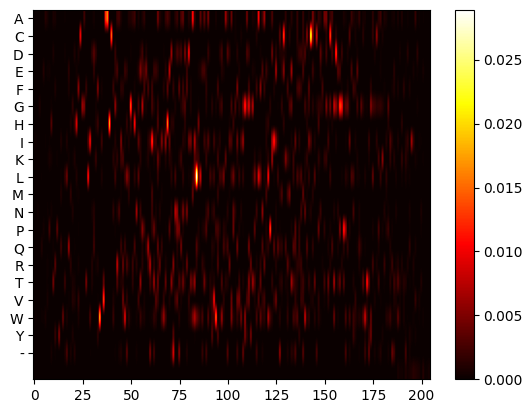

In [40]:
from captum.attr import FeatureAblation

feature_ablation = FeatureAblation(wrapped_model)

attributes3 = feature_ablation.attribute(test_data.permute(0,2,1), target = 3, show_progress = True)

attributes3 = attributes3.cpu().detach().numpy()
plt.imshow(np.abs(attributes3.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

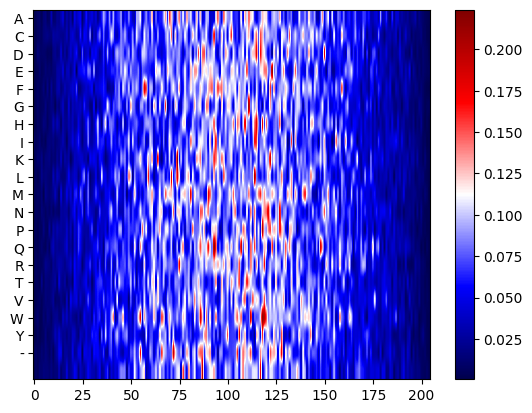

In [41]:
attributions_value_final = np.abs(attributions_values0.sum(axis=0))+np.abs(attributions_values1.sum(axis=0))+np.abs(attributions_values2.sum(axis=0))+np.abs(attributions_values3.sum(axis=0))
plt.imshow(attributions_value_final, cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()

Feature Permutation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

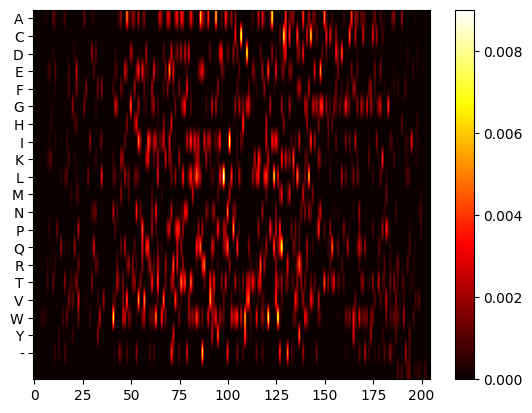

In [42]:
from captum.attr import FeaturePermutation

feature_permutation = FeaturePermutation(wrapped_model)

#test_data0 = torch.tensor(seq_OH[50:60], dtype = torch.float32).to(args.DEVICE)

attributions0 = feature_permutation.attribute(test_data.permute(0,2,1), show_progress = True, target = 0)

attributions_values0 = attributions0.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values0.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Permutation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

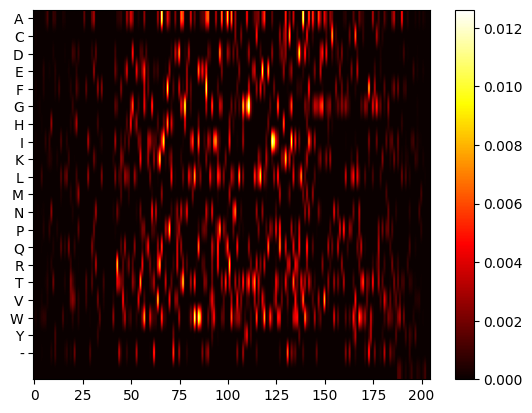

In [43]:
from captum.attr import FeaturePermutation

feature_permutation = FeaturePermutation(wrapped_model)

#test_data0 = torch.tensor(seq_OH[50:60], dtype = torch.float32).to(args.DEVICE)

attributions1 = feature_permutation.attribute(test_data.permute(0,2,1), show_progress = True, target = 1)

attributions_values1 = attributions1.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values1.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Permutation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

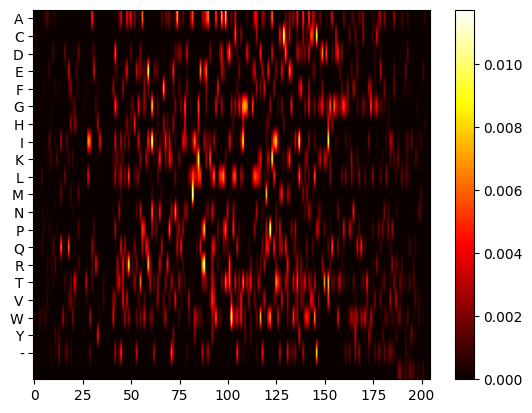

In [44]:
from captum.attr import FeaturePermutation

feature_permutation = FeaturePermutation(wrapped_model)

#test_data0 = torch.tensor(seq_OH[50:60], dtype = torch.float32).to(args.DEVICE)

attributions2 = feature_permutation.attribute(test_data.permute(0,2,1), show_progress = True, target = 2)

attributions_values2 = attributions2.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values2.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

Feature Permutation attribution:   0%|          | 0/4306 [00:00<?, ?it/s]

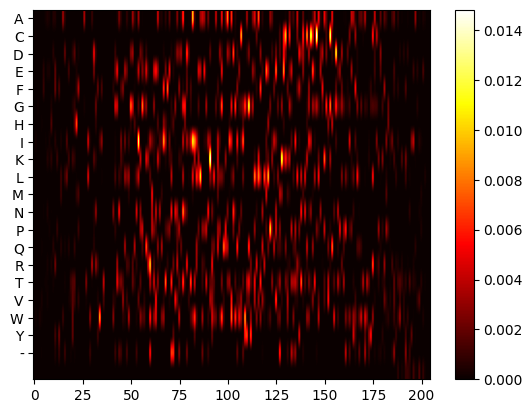

In [45]:
from captum.attr import FeaturePermutation

feature_permutation = FeaturePermutation(wrapped_model)

#test_data0 = torch.tensor(seq_OH[50:60], dtype = torch.float32).to(args.DEVICE)

attributions3 = feature_permutation.attribute(test_data.permute(0,2,1), show_progress = True, target = 3)

attributions_values3 = attributions3.cpu().detach().numpy()

plt.imshow(np.abs(attributions_values3.sum(axis=0)), cmap = 'hot', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar() 

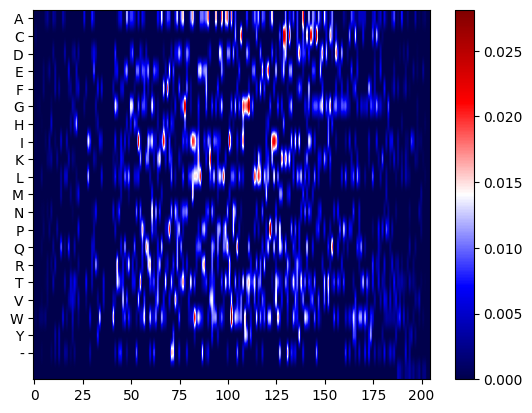

In [46]:
attributions_value_final = np.abs(attributions_values0.sum(axis=0))+np.abs(attributions_values1.sum(axis=0))+np.abs(attributions_values2.sum(axis=0))+np.abs(attributions_values3.sum(axis=0))
plt.imshow(attributions_value_final, cmap = 'seismic', aspect = 'auto')
plt.yticks(range(len(protein_string)), protein_string)
plt.colorbar()